***
# Introduction
***
**Вводные**
<br>Клиентами Fundraise Up являются организации (нонпрофиты), которые собирают пожертвования на благотворительные цели.
Fundraise Up предоставляет продукт, который помогает нонпрофитам собирать пожертвования онлайн.
Одним из ключевых элементов продукта является `чекаут` — это форма, которую `видит` `пользователь` (донор), когда `собирается` `сделать` `пожертвование` на сайте нонпрофита.
Совершая донат, пользователь может выбрать 1 из 6 предложенных сумм, оставить дефолтную сумму (30$ на примере), либо ввести любую другую сумму.
Естественно, `не каждое открытие чекаута завершается пожертвованием`.

**Задача**
<br>`Построить модель, предсказывающую вероятность совершения пожертвования (конверсии)`, на основе предоставленных данных.

**Датасет**<br>
`FundraiseUp_DS_test_dataset.csv`
<br>Каждая `строчка датасета` - одна `сессия внутри чекаута`. `Целевая метрика` - конверсия в донат (`столбец “Conversion”`)

**Описание столбцов:**<br><font size="2">
• CheckoutViewID - Уникальный ID просмотра чекаута<br>
• SessionStartTime - Дата и время начала сессии<br>
• OS - Операционная система<br>
• IsMobile - Флаг мобильного клиента<br>
• IsTablet - Флаг планшета (это тоже мобильный клиент)<br>
• Device - Название устройства<br>
• Browser - Имя User Agent<br>
• UAMajor - Мажорная версия User Agent<br>
• UAIsInApp - Флаг - встроенный браузер в приложение (например тикток, инстаграм)<br>
• SessionStartSource - Источник траффика (google, google_ads, и т.д.)<br>
• ElementType - Тип элемента, через который был открыт чикают<br>
• ClientIPCountry - Код страны пользователя, определенный по IP<br>
• ClientIPRegion - Регион пользователя, определенный по IP<br>
• ClientIPCity - Город пользователя, определенный по IP<br>
• ClientIPConnectionType - Тип соединения с интернетом Dialup, Cable/DSL, Corporate, or Cellular<br>
• ClientDevicePixelRatio - Плотность пикселей экрана<br>
• ClientDeviceMemory - Примерный размер оперативной памяти<br>
• ClientConnectionEffectiveType - Скорость интернета<br>
• ClientBatteryCharging - Флаг, заряжается ли батарейка<br>
• CheckoutCurrency - Валюта, выбранная в чекауте<br>
• MinPresetAmount - Минимальный размер подсказки (из 6 предложенных значений)<br>
• MaxPresetAmount - Максимальный размер подсказки (из 6 предложенных значений)<br>
• AvgPresetAmount - Средний размер подсказки (из 6 предложенных значений)<br>
• DefaultPresetAmount - Дефолтный (предзаполненный) размер доната<br>
• CompanyConversion - Средняя конверсия нонпрофита за последние 6 месяцев<br>
• **Conversion** - Флаг, совершен ли донат в этой сессии (целевая метрика)<br>
</font>

***
# Understanding
***
1) Problem: It looks like a binary regression problem (`вероятность совершения пожертвования`)<br>
2) Data: We have a lot of different independent variables, and probably of different types to deal with (numerical, categorical, unusefull)<br>
3) Business: There is likely a desire to focus more on the most likely converting users in order to reduce costs or optimize efforts.<br>
 <br>*I would also suggest other option for business: what donation amount to make default in each individual case to increase the conversion probability (hypothesis: the fewer actions a user performs, the less likely it is that he/she will "fall off" in the sequence of actions, i.e. user will not have to edit the default amount and it will not cause a negative reaction) - but that is a different story (just a thought on how to quickly focus on local correlations: K-Nearest by features -> 2D densities of donat value(X) vs success/unsuccess(Y:1/0) -> choose Mode-value on X of biggest Y=1 cluster)*

***
# Data processing
***

We have:<br>
FundraiseUp_DS_test_dataset.csv - one file with many different columns and the target as the last one column

In [1]:
import pandas as pd

# reusables
def f_df_check(df:pd.DataFrame, values_length_trshld)->pd.DataFrame:
    s1 = df.isna().agg(['sum']).rename({'sum':'NA'}).T
    s2 = (~df.isna()).agg(['sum']).rename({'sum':'not-NA'}).T
    s3 = (s1['NA']/(s1['NA']+s2['not-NA']) *100).apply(lambda x: round(x,1))
    s3 = s3.rename('NA %').to_frame()
    res = \
    pd.concat([df.dtypes.to_frame('dtype'),
               df.nunique().to_frame('nunique'),
               s1, s2, s3,
               (df=='').agg(['sum']).rename({'sum':'empty'}).T,
               df.applymap(lambda x: len(str(x))<values_length_trshld).agg(['sum']).rename({'sum':f'length<{values_length_trshld}'}).T,
              ],
              axis=1
             )
    return res

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/FundriseUP/')

Mounted at /content/drive


***
FundraiseUp_DS_test_dataset.csv as "df_0", Raw data processing/cleaning
***

In [3]:
## let's have a look at the start of the file to be able to determine the parsing rules (e.g. which separator?)
with open('FundraiseUp_DS_test_dataset.csv','rt') as f:
  print(repr(f.read(1000)))

'"CheckoutViewID";"SessionStartTime";"OS";"IsMobile";"IsTablet";"Device";"Browser";"UAMajor";"UAIsInApp";"SessionStartSource";"ElementType";"ClientIPCountry";"ClientIPRegion";"ClientIPCity";"ClientIPConnectionType";"ClientDevicePixelRatio";"ClientDeviceMemory";"ClientConnectionEffectiveType";"ClientBatteryCharging";"CheckoutCurrency";"MinPresetAmount";"MaxPresetAmount";"AvgPresetAmount";"DefaultPresetAmount";"CompanyConversion";"Conversion"\n5006627551024496702;2023-10-06 16:46:10;Android;1;0;Samsung;Chrome;117;0;googleAds;direct;TH;Bangkok;Bangkok;Cable/DSL;1.97;8.00;"4g";1;THB;190.0;6000.0;2198.3333333333335;800.0;2.29;0\n3558387460918962996;2023-10-23 04:01:04;Android;1;0;Samsung;Facebook;435;1;unknown;textLink;IN;Maharashtra;Mumbai;Cellular;2.63;4.00;"4g";0;INR;1000.0;50000.0;14666.666666666668;2000.0;12.4;0\n7768252951217063319;2023-10-21 17:33:14;Windows;0;0;"";Chrome;109;0;unknown;donateButton;US;Florida;Winter Park;Cable/DSL;1.00;2.00;"3g";1;USD;75.0;500.0;212.5;0.0;14.7;0\n232

***
separator = ';'<br>
everything else pandas can handle
***

In [4]:
df_0 = pd.read_csv('FundraiseUp_DS_test_dataset.csv',sep=';')
print(df_0.head().to_string() )

        CheckoutViewID     SessionStartTime       OS  IsMobile  IsTablet   Device   Browser  UAMajor  UAIsInApp SessionStartSource   ElementType ClientIPCountry ClientIPRegion ClientIPCity ClientIPConnectionType  ClientDevicePixelRatio  ClientDeviceMemory ClientConnectionEffectiveType  ClientBatteryCharging CheckoutCurrency  MinPresetAmount  MaxPresetAmount  AvgPresetAmount  DefaultPresetAmount  CompanyConversion  Conversion
0  5006627551024496702  2023-10-06 16:46:10  Android         1         0  Samsung    Chrome      117          0          googleAds        direct              TH        Bangkok      Bangkok              Cable/DSL                    1.97                 8.0                            4g                      1              THB            190.0           6000.0      2198.333333                800.0               2.29           0
1  3558387460918962996  2023-10-23 04:01:04  Android         1         0  Samsung  Facebook      435          1            unknown      textLi

In [5]:
df = df_0.copy()
print('custom checks'); print(f_df_check(df, 1).to_string(),'\n')
print('DataFrame.describe()'); print(df.describe(),'\n')

custom checks
                                 dtype  nunique      NA   not-NA  NA %  empty  length<1
CheckoutViewID                  uint64   999999       0  1000000   0.0      0         0
SessionStartTime                object   797550       0  1000000   0.0      0         0
OS                              object       18     226   999774   0.0      0         0
IsMobile                         int64        2       0  1000000   0.0      0         0
IsTablet                         int64        2       0  1000000   0.0      0         0
Device                          object       41  598974   401026  59.9      0         0
Browser                         object       49     342   999658   0.0      0         0
UAMajor                          int64      409       0  1000000   0.0      0         0
UAIsInApp                        int64        2       0  1000000   0.0      0         0
SessionStartSource              object       21       0  1000000   0.0      0         0
ElementType       

***
A lot of categorical values. On the other hand, as far as we have a lot of data - we are good to go with "Ordinal Encoding" and build a NN to catch nonlinear dependency and so to get a good projection to target. I think we must go this way to use all the data. But we must be carefull to not to overfit.<br>

And why is that CheckoutViewID's unique values isn't equal to the total of rows?<br>
Looks like we have 2 rows that have at least same CheckoutViewID
***

In [6]:
df = df[df.duplicated(subset=['CheckoutViewID'],keep=False)]
print(df.to_string(),'\n')
print('are they full duplicates?\n', df.duplicated(keep=False).to_string())

             CheckoutViewID     SessionStartTime       OS  IsMobile  IsTablet Device Browser  UAMajor  UAIsInApp SessionStartSource ElementType ClientIPCountry ClientIPRegion ClientIPCity ClientIPConnectionType  ClientDevicePixelRatio  ClientDeviceMemory ClientConnectionEffectiveType  ClientBatteryCharging CheckoutCurrency  MinPresetAmount  MaxPresetAmount  AvgPresetAmount  DefaultPresetAmount  CompanyConversion  Conversion
411008  4991232533410678491  2023-10-31 02:29:37  Android         1         0    NaN  Chrome      118          0            unknown      direct              US       Maryland       Laurel              Cable/DSL                    2.63                 8.0                            3g                      0              USD             54.0           1800.0       655.666667                  0.0              72.08           1
566418  4991232533410678491  2023-10-31 02:29:37  Android         1         0    NaN  Chrome      118          0            unknown      direct 

***
thought we might have two different situations for same checkout. but it's two fully identical rows.
<br>full duplicates must be dropped off.
***

In [7]:
df_0 = df_0.drop_duplicates()
df = df_0.copy()

***
Thoughts: <br>
1) CheckoutViewID -> we will not use it as a feature (always unique encoded ID, no direct statistics)<br>
2) SessionStartTime -> extract hod, dow, moy and drop the source. AND I hope it's in UTC for simplicity here (*or else we will need to try to know the timezone from geo as an example*)<br>
3) We have NAs in Categoricals. Different approaches exists for it to deal and it's important to fill it statistically for simple models (*e.g. for linear*) (*like "OS" is only 226 out of 999774 rows are empty and it could be filled with the mode or the mean, or 59.9% of "Device" is NA so we may just drop it now*) - BUT we will go with NN as a model wich is good with non-linearity so let's do just 2 things for all Categoricals: fill NAs with "unknown" and encode with "Ordinal Encoding"<br>
4) *CheckoutCurrency may be correlated with ClientIPCountry and may be dropped off at the first glance, but nowadays some people using different banks and currencies, and maybe for donations it's also reasonable, let's leave it*<br>
5) We have geo taxonomical dependency: ClientIPCountry -> ClientIPRegion -> ClientIPCity. And since we will use "Ordinal Encoding" lets triple sort them and only after do the encoding (*to be sure that geo-subdomains are geo-grouped by order at least. Btw, would also be a good idea to use geo coordinates instead, like longitude and latitude, coz they are naturally have locality in real space*)
***

In [8]:
df_0 = df_0.drop('CheckoutViewID', axis=1)

***
SessionStartTime
***

In [9]:
print(df['SessionStartTime'].iloc[:10].to_string())

0    2023-10-06 16:46:10
1    2023-10-23 04:01:04
2    2023-10-21 17:33:14
3    2023-10-18 03:53:36
4    2023-10-27 20:29:23
5    2023-10-17 15:09:56
6    2023-10-21 12:59:56
7    2023-10-11 16:00:11
8    2023-10-17 23:06:25
9    2023-10-22 16:16:30


In [10]:
def dataprocess_extract_hod_dow_moy(srs)->pd.DataFrame:
  s_dt = pd.to_datetime(srs, format='%Y-%m-%d %H:%M:%S')
  r_hod = s_dt.apply(lambda x: x.hour).rename('dt_hod') #hour of day
  r_dow = s_dt.apply(lambda x: x.weekday()).rename('dt_dow') #day of week
  r_moy = s_dt.apply(lambda x: x.month).rename('dt_moy') #month of year
  return pd.concat([r_hod, r_dow, r_moy], axis=1) #DataFrame

In [11]:
df = dataprocess_extract_hod_dow_moy(df_0['SessionStartTime'])
print(df.iloc[:10,:].to_string())
print(df.nunique().to_string())

   dt_hod  dt_dow  dt_moy
0      16       4      10
1       4       0      10
2      17       5      10
3       3       2      10
4      20       4      10
5      15       1      10
6      12       5      10
7      16       2      10
8      23       1      10
9      16       6      10
dt_hod    24
dt_dow     7
dt_moy     3


In [12]:
df_0 = pd.concat([df_0, df], axis=1) # add new columns
df_0 = df_0.drop(labels=['SessionStartTime',], axis=1) # drop source

In [13]:
# let's check it
print(df_0.iloc[:10,-4:].to_string())

   Conversion  dt_hod  dt_dow  dt_moy
0           0      16       4      10
1           0       4       0      10
2           0      17       5      10
3           0       3       2      10
4           0      20       4      10
5           0      15       1      10
6           0      12       5      10
7           0      16       2      10
8           0      23       1      10
9           0      16       6      10


***
NAs in Categoricals -> "unknown"
***

In [14]:
columns_seen_categorical = \
 ['OS', 'Device', 'Browser', 'SessionStartSource', 'ElementType',
  'ClientIPCountry', 'ClientIPRegion', 'ClientIPCity',
  'ClientIPConnectionType', 'ClientConnectionEffectiveType', 'CheckoutCurrency',
  ]

df_0 = df_0.fillna(dict.fromkeys(columns_seen_categorical, 'unknown'))

In [15]:
# let's check it
print(f_df_check(df_0, 1).to_string())

                                 dtype  nunique  NA  not-NA  NA %  empty  length<1
OS                              object       19   0  999999   0.0      0         0
IsMobile                         int64        2   0  999999   0.0      0         0
IsTablet                         int64        2   0  999999   0.0      0         0
Device                          object       42   0  999999   0.0      0         0
Browser                         object       50   0  999999   0.0      0         0
UAMajor                          int64      409   0  999999   0.0      0         0
UAIsInApp                        int64        2   0  999999   0.0      0         0
SessionStartSource              object       21   0  999999   0.0      0         0
ElementType                     object       20   0  999999   0.0      0         0
ClientIPCountry                 object      234   0  999999   0.0      0         0
ClientIPRegion                  object     2339   0  999999   0.0      0         0
Clie

***
ClientIPCountry -> ClientIPRegion -> ClientIPCity
***

In [16]:
# sorting by 3 levels
df_0 = df_0.sort_values(by=['ClientIPCountry','ClientIPRegion','ClientIPCity'])

***
ready for "Ordinal Encoding" for each column.

Must presave the encoder state and use it with the model both on inference phase and on re-train.
***

In [17]:
from sklearn.preprocessing import OrdinalEncoder

In [18]:
features_encoder = OrdinalEncoder(categories = [df_0[i].unique().tolist() for i in columns_seen_categorical], # presaving sorted geo order ('auto' will make lexicographical order, but we don't want it)
                                  encoded_missing_value=-1, ) # if we will get unknown values in future inference phase (like in production) then we can return just -1, but it's better to log such a case and schedule re-training the pipe
features_encoder = features_encoder.fit(df_0[columns_seen_categorical])

In [19]:
# postfix to new namings
columns_seen_categorical_numbered = [str(j)+'_'+str(i) for i,j in enumerate(columns_seen_categorical)]
# add trnaformed columns
df_0.loc[:,columns_seen_categorical_numbered] = features_encoder.transform(df_0.loc[:,columns_seen_categorical])

In [20]:
# let's check that order presaved (ClientIPCountry_5  ClientIPRegion_6  ClientIPCity_7 must be 0 in upper rows)
print(df_0[columns_seen_categorical + columns_seen_categorical_numbered].iloc[:10,:].to_string())

             OS   Device   Browser SessionStartSource ElementType ClientIPCountry    ClientIPRegion      ClientIPCity ClientIPConnectionType ClientConnectionEffectiveType CheckoutCurrency  OS_0  Device_1  Browser_2  SessionStartSource_3  ElementType_4  ClientIPCountry_5  ClientIPRegion_6  ClientIPCity_7  ClientIPConnectionType_8  ClientConnectionEffectiveType_9  CheckoutCurrency_10
48194   Android  unknown  Facebook        facebookAds      direct              AD  Andorra la Vella  Andorra la Vella              Cable/DSL                            4g              EUR   0.0       0.0        0.0                   0.0            0.0                0.0               0.0             0.0                       0.0                              0.0                  0.0
106424  Windows  unknown    Chrome            unknown      direct              AD  Andorra la Vella  Andorra la Vella              Cable/DSL                            4g              EUR   1.0       0.0        1.0                

In [21]:
# drop source columns
df_0 = df_0.drop(columns_seen_categorical, axis=1)

In [22]:
# let's check it
print(f_df_check(df_0, 1).to_string())

                                   dtype  nunique  NA  not-NA  NA %  empty  length<1
IsMobile                           int64        2   0  999999   0.0      0         0
IsTablet                           int64        2   0  999999   0.0      0         0
UAMajor                            int64      409   0  999999   0.0      0         0
UAIsInApp                          int64        2   0  999999   0.0      0         0
ClientDevicePixelRatio           float64      400   0  999999   0.0      0         0
ClientDeviceMemory               float64        9   0  999999   0.0      0         0
ClientBatteryCharging              int64        2   0  999999   0.0      0         0
MinPresetAmount                  float64      131   0  999999   0.0      0         0
MaxPresetAmount                  float64      180   0  999999   0.0      0         0
AvgPresetAmount                  float64     3132   0  999999   0.0      0         0
DefaultPresetAmount              float64      682   0  999999   0

In [23]:
# last step - make all them float explicitly
df_0 = df_0.apply(lambda x: x if x.dtype=='float' else x.astype('float'), axis=0)

In [24]:
# let's check it
print(f_df_check(df_0, 1).to_string())

                                   dtype  nunique  NA  not-NA  NA %  empty  length<1
IsMobile                         float64        2   0  999999   0.0      0         0
IsTablet                         float64        2   0  999999   0.0      0         0
UAMajor                          float64      409   0  999999   0.0      0         0
UAIsInApp                        float64        2   0  999999   0.0      0         0
ClientDevicePixelRatio           float64      400   0  999999   0.0      0         0
ClientDeviceMemory               float64        9   0  999999   0.0      0         0
ClientBatteryCharging            float64        2   0  999999   0.0      0         0
MinPresetAmount                  float64      131   0  999999   0.0      0         0
MaxPresetAmount                  float64      180   0  999999   0.0      0         0
AvgPresetAmount                  float64     3132   0  999999   0.0      0         0
DefaultPresetAmount              float64      682   0  999999   0

In [25]:
# stats... do we have a tails?
print('DataFrame.describe()'); print(df_0.describe().to_string(),'\n')

DataFrame.describe()
            IsMobile       IsTablet        UAMajor      UAIsInApp  ClientDevicePixelRatio  ClientDeviceMemory  ClientBatteryCharging  MinPresetAmount  MaxPresetAmount  AvgPresetAmount  DefaultPresetAmount  CompanyConversion     Conversion         dt_hod         dt_dow         dt_moy           OS_0       Device_1      Browser_2  SessionStartSource_3  ElementType_4  ClientIPCountry_5  ClientIPRegion_6  ClientIPCity_7  ClientIPConnectionType_8  ClientConnectionEffectiveType_9  CheckoutCurrency_10
count  999999.000000  999999.000000  999999.000000  999999.000000           999999.000000       999999.000000          999999.000000     9.999990e+05     9.999990e+05     9.999990e+05         9.999990e+05      999999.000000  999999.000000  999999.000000  999999.000000  999999.000000  999999.000000  999999.000000  999999.000000         999999.000000  999999.000000      999999.000000     999999.000000   999999.000000             999999.000000                    999999.000000   

***
we could further analize distributions and come up with appropriate transformations to make them more like Normal Standard (gaussian) that would speed up the training and probably make train metrics better (since values would be more appropriately distributed in each dimension in which optimization algorithm would operate to find an optimum)

But for now let's just apply StandardScaler normalizer and stop.
***

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
features_normalizer = StandardScaler()
features_normalizer = features_normalizer.fit(df_0[df_0.columns.drop('Conversion')]) # conversion is already in [0..1] (0 or 1, more precisely) for use with sigmoid function
# apply normalizer to all columns, except target
df_0.loc[:, df_0.columns.drop('Conversion')] = features_normalizer.transform(df_0[df_0.columns.drop('Conversion')])

In [28]:
print(df_0.iloc[:10,:].to_string())

        IsMobile  IsTablet   UAMajor  UAIsInApp  ClientDevicePixelRatio  ClientDeviceMemory  ClientBatteryCharging  MinPresetAmount  MaxPresetAmount  AvgPresetAmount  DefaultPresetAmount  CompanyConversion  Conversion    dt_hod    dt_dow    dt_moy      OS_0  Device_1  Browser_2  SessionStartSource_3  ElementType_4  ClientIPCountry_5  ClientIPRegion_6  ClientIPCity_7  ClientIPConnectionType_8  ClientConnectionEffectiveType_9  CheckoutCurrency_10
48194   0.896381 -0.123804  2.425085   2.336857                0.857648            1.201292              -0.640170        -0.095531        -0.099993        -0.097806            -0.027820          -0.002940         0.0  1.621173  1.141997 -0.203518 -1.073725 -0.429152  -1.050186             -0.752975      -0.441884          -1.956653         -1.602926       -1.584275                 -0.632901                        -0.824709            -0.563696
106424 -1.115597 -0.123804 -0.077254  -0.427925               -1.244984            1.201292           

***
One more thing. What imbalance we have of Conversion 1 vs 0?
***

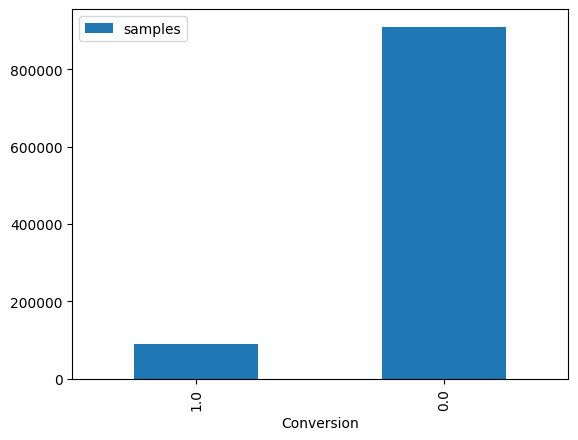

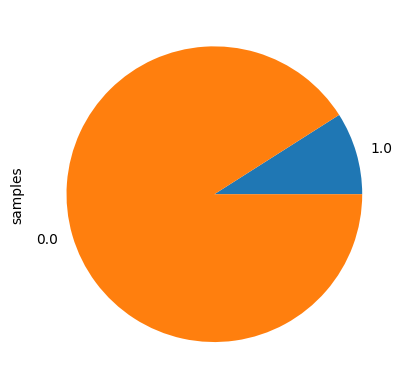


Imbalance?

            samples  samples_%
Conversion                    
1.0           90111       9.01
0.0          909888      90.99


In [29]:
import matplotlib.pyplot as plt
df = df_0.groupby(by='Conversion').count().iloc[:,1].sort_values().to_frame('samples')
df.plot(kind='bar'); plt.show();
df.plot(kind='pie', y='samples', legend=False); plt.show();
print('\nImbalance?\n')
df['samples_%'] = (df/(df.iloc[0,:] + df.iloc[1,:])*100)['samples'].apply(lambda x: round(x,2))
print(df.to_string())

***
Yeap, imbalance. Typical for binary cases. We have ~1/10 chance to conversion on average. We will need to fix it for model training (most natural and stable way is to do minor class upsampling - that will balance out NN's free parameters usage and the decision borders for target's topology over feature space, from the data rather than by assumptions)
***

***
Summary of section<br>
We preprocessed data enough to build a model. We hope that NN further will handle nonlinearity that we left (but additional steps might be offcourse applied)<br>

For the production version don't forget to put tugether with the model:<br>
1) columns namings<br>
2) features_encoder<br>
3) features_normalizer<br>
4) routines (e.g. dataprocess_extract_hod_dow_moy() function, and pack the sequence of processing steps into 2 beautiful functions: one for training and one for inference (the difference is that in inference case we do only "transform" by encoder and normalizer) - or other approach (better to split at least to 3 services:<br>
(0) data preprocessing -> {(1),(2)}, <br>
(1) training (encoder, normalizer, model) <br>
(2) inference (encoder, normalizer, model) ))<br>
***

***
# Modelling
***

***
The plan is to build NN model for Binary Regression.
I chose NN because we can effectively project complex inputs that we have in a flexible non-linear way up to sigmoid output function.
***

***
## Baseline model
***

In [30]:
import numpy as np

# split the data to 3 parts with preserving ratio for 2 classes (stratifying)
from sklearn.model_selection import train_test_split

x_all, y_all = df_0[df_0.columns.drop('Conversion')].values, df_0[['Conversion']].values
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all,
                                                    test_size = 0.3, #70% to train
                                                    stratify = y_all, random_state = 32)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test,
                                                    test_size = 0.5, # 15% to validation and 15% to test
                                                    stratify = y_test, random_state = 32)

# will need it here to be sure and maybe after (like after upsampling the minor class)
def shuffle_xy(x,y):
  result = (x,y)
  ids = np.arange(y.shape[0])
  np.random.shuffle(ids)
  result = (x[ids], y[ids])
  return result

x_train, y_train = shuffle_xy(x_train, y_train)

In [31]:
!pip install tensorflow
import tensorflow as tf
import gc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [32]:
def build_model(features_cnt : int,
                hidden_neurons     : list = [300,    200,    100   ],
                hidden_activations : list = ['tanh', 'tanh', 'tanh'],
                learning_rate : float = 1e-4,
                metrics : list = [],
                ):
    """
    builds a model with functional API
    """
    inputs = tf.keras.layers.Input(shape=(features_cnt,))
    h = inputs

    for l in range(len(hidden_neurons)):
      h = tf.keras.layers.Dense(units = hidden_neurons[l], activation = hidden_activations[l], kernel_regularizer = tf.keras.regularizers.l1_l2(1e-6, 1e-5))(h)
      h = tf.keras.layers.BatchNormalization()(h)
    outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(h)

    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)

    model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

    return model

In [45]:
#tf reset routines for restarting multiple times (to prevent duplicating graph and memory leakage)
strategy = None
model = None
del strategy
del model

#tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session() # reset_default_graph is called inside
_ = gc.collect()
del _

strategy = tf.distribute.get_strategy() #tf.distribute.MirroredStrategy() #tf.distribute.TPUStrategy()
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
FEATURES_CNT = x_all.shape[1]
HIDDEN_NEURONS     = [20000,    300,    200,     100,    ]
HIDDEN_ACTIVATIONS = ['tanh', 'tanh', 'tanh',  'tanh', ]
LEARNING_RATE = 1e-3

EPOCHS = 100
BATCH_SIZE = 2048 * strategy.num_replicas_in_sync
METRICS = [ #AUPRC is best one to use
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'), # true positives (def 0.5 threshold)
      tf.keras.metrics.FalsePositives(name='fp'), # false positives (def 0.5 threshold)
      tf.keras.metrics.TrueNegatives(name='tn'), # true negatives (def 0.5 threshold)
      tf.keras.metrics.FalseNegatives(name='fn'), # false negatives (def 0.5 threshold)
      tf.keras.metrics.BinaryAccuracy(name='accuracy'), # percentage of examples correctly classified (def 0.5 threshold)
      tf.keras.metrics.Precision(name='precision'), # tp/(tp+fp) #correctly recognized as positive over all recognized as positive (def 0.5 threshold)
      tf.keras.metrics.Recall(name='recall'), # tp/(tp+fn) #correctly recognized as positive over all actual positives (def 0.5 threshold)
      tf.keras.metrics.AUC(name='auc', curve='ROC'), # AUCROC: Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). (def 200 lin spaced thresholds). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve (def 200 lin spaced thresholds) (AUPRC: Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds)
]


# build tensorflow's DataSet object
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048*2)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .shuffle(2048*2)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# callbacks to not to overfit.
# we monitoring val_prc metric and if it's not improving then RLP will slow down Lr and if many epochs no improvements at all - stop and return weights with which we had best val_prc
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_prc', mode='max', patience=2, verbose=1, factor=0.1) #will slow down Lr by Factor if Patience-time consecutive epochs no improvements on Monitored metric
es = tf.keras.callbacks.EarlyStopping(monitor='val_prc', mode='max', patience=6, verbose=1, restore_best_weights=True, min_delta=1e-6) # will stop the training and return best weights if no improvement on Monitored metric

In [46]:
with strategy.scope():
    model = build_model(FEATURES_CNT,
                        HIDDEN_NEURONS,
                        HIDDEN_ACTIVATIONS,
                        LEARNING_RATE,
                        METRICS)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense (Dense)               (None, 20000)             540000    
                                                                 
 batch_normalization (Batch  (None, 20000)             80000     
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 300)               6000300   
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 200)               60200 

In [47]:
#check
model.predict(x_train[:10])

1/1 [==============================] - 0s 206ms/step


array([[0.5105761 ],
       [0.56500405],
       [0.47565565],
       [0.54129267],
       [0.47262564],
       [0.54437757],
       [0.48083815],
       [0.46614742],
       [0.5716633 ],
       [0.5019878 ]], dtype=float32)

***
Train the model (baseline)
***

In [48]:
n_steps = max(1, x_train.shape[0] // BATCH_SIZE) # steps per epoch

hist_baseline = model.fit(
    train_dataset,
    validation_data = val_dataset,
    steps_per_epoch = n_steps,
    epochs = EPOCHS,
    callbacks = [rlp, es],
)

Epoch 1/100
341/341 [==============================] - 29s 72ms/step - loss: 0.4163 - cross entropy: 0.3417 - Brier score: 0.1000 - tp: 11732.0000 - fp: 29618.0000 - tn: 605818.0000 - fn: 51200.0000 - accuracy: 0.8843 - precision: 0.2837 - recall: 0.1864 - auc: 0.7164 - prc: 0.1939 - val_loss: 0.3134 - val_cross entropy: 0.2444 - val_Brier score: 0.0702 - val_tp: 982.0000 - val_fp: 820.0000 - val_tn: 135663.0000 - val_fn: 12535.0000 - val_accuracy: 0.9110 - val_precision: 0.5450 - val_recall: 0.0726 - val_auc: 0.8184 - val_prc: 0.3242 - lr: 0.0010
Epoch 2/100
341/341 [==============================] - 22s 66ms/step - loss: 0.3046 - cross entropy: 0.2409 - Brier score: 0.0694 - tp: 6115.0000 - fp: 5345.0000 - tn: 630103.0000 - fn: 56805.0000 - accuracy: 0.9110 - precision: 0.5336 - recall: 0.0972 - auc: 0.8250 - prc: 0.3368 - val_loss: 0.2973 - val_cross entropy: 0.2389 - val_Brier score: 0.0692 - val_tp: 1986.0000 - val_fp: 2043.0000 - val_tn: 134440.0000 - val_fn: 11531.0000 - val_acc

In [49]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Detected low conversion correctly (True Negatives): ', cm[0][0])
  print('Detected low conversion wrongly (False Negatives): ', cm[1][0])
  print('Detected high conversion correctly (True Positives): ', cm[1][1])
  print('Detected high conversion wrongly (False Positives): ', cm[0][1])


  print('Total high conversions: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, threshold = roc_curve(labels.reshape(-1), predictions.reshape(-1))
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  # plt.xlim([-0.5,20])
  plt.xlim([-0.5,100.5])
  # plt.ylim([80,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, threshold = precision_recall_curve(labels.reshape(-1), predictions.reshape(-1))
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

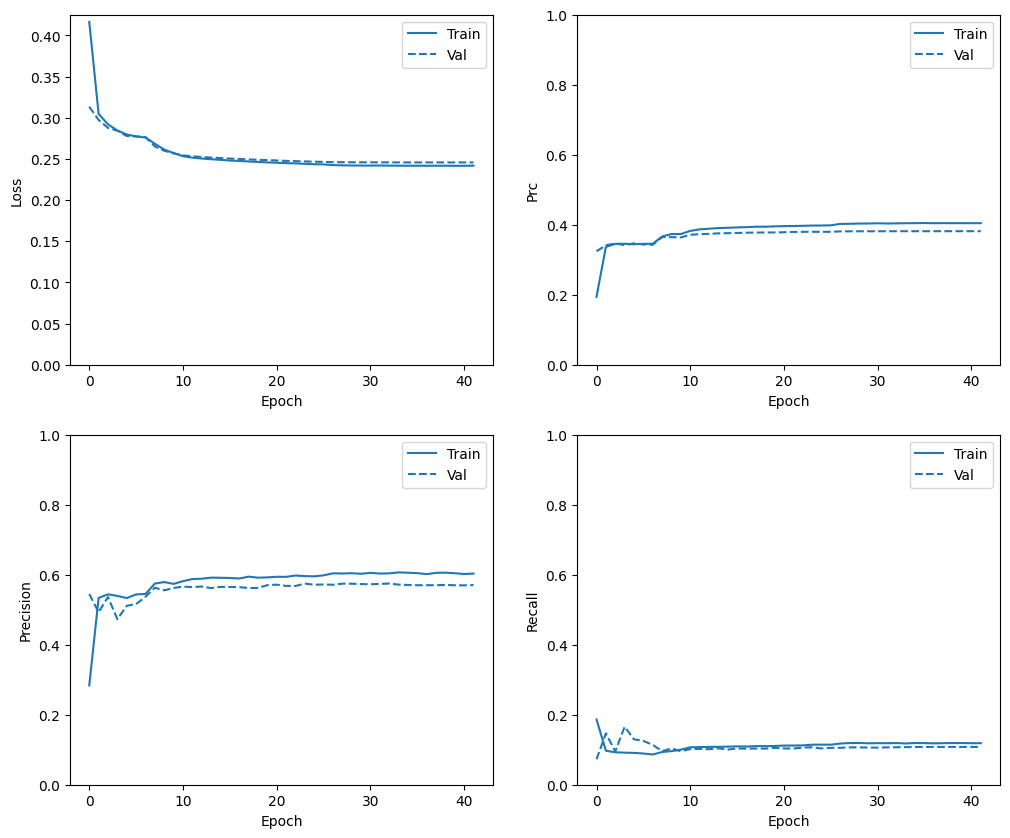

74/74 [==============================] - 1s 17ms/step
loss :  0.24569116532802582
cross entropy :  0.22670981287956238
Brier score :  0.06618796288967133
tp :  1511.0
fp :  1122.0
tn :  135362.0
fn :  12005.0
accuracy :  0.9124866724014282
precision :  0.5738701224327087
recall :  0.11179342865943909
auc :  0.8535107970237732
prc :  0.3858654499053955

Detected low conversion correctly (True Negatives):  135362
Detected low conversion wrongly (False Negatives):  12005
Detected high conversion correctly (True Positives):  1511
Detected high conversion wrongly (False Positives):  1122
Total high conversions:  13516


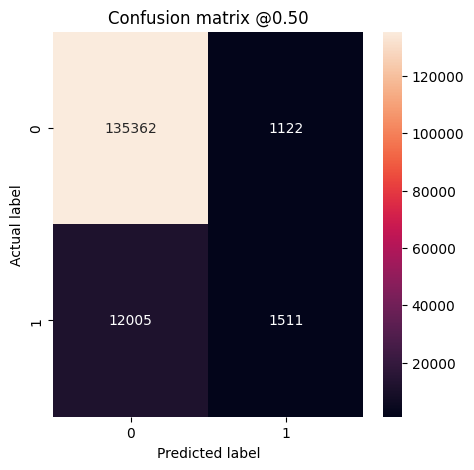

342/342 [==============================] - 6s 17ms/step


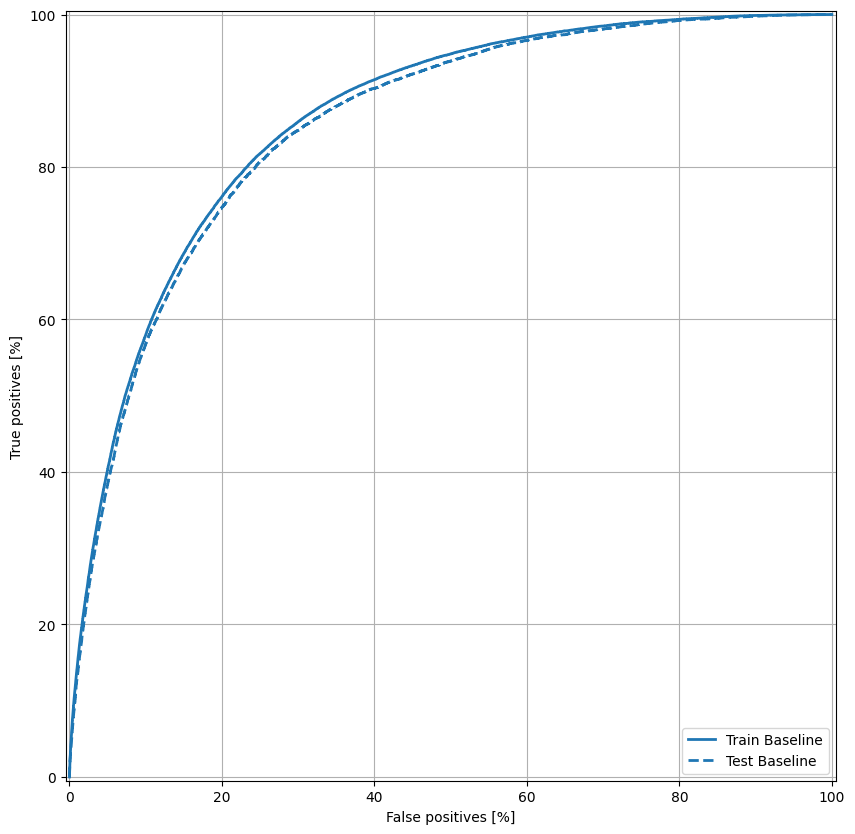

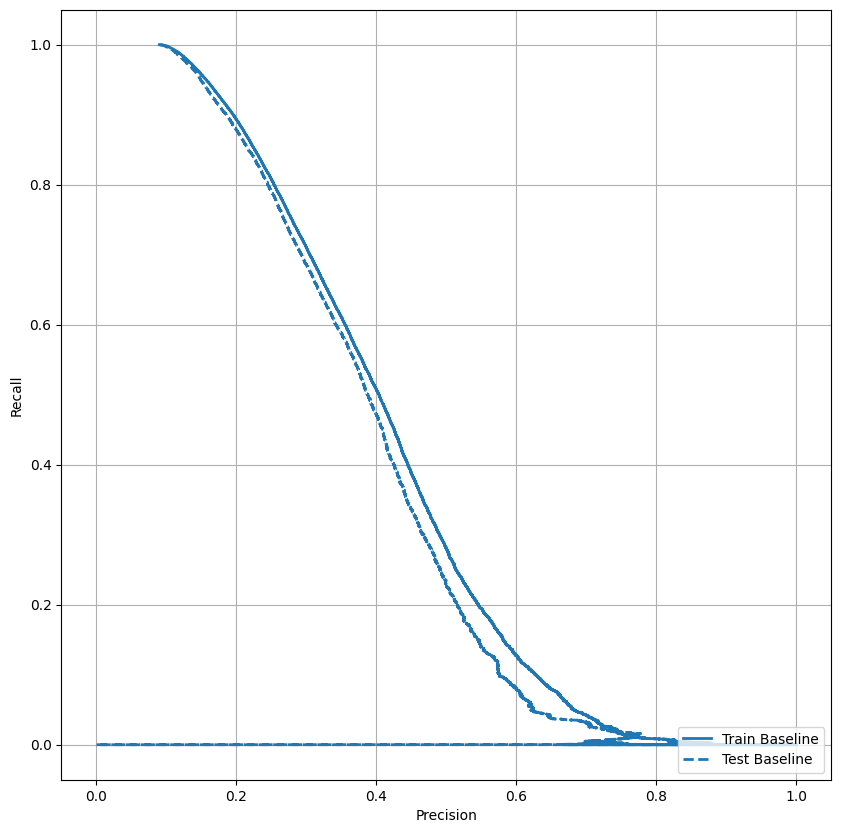

In [50]:
# metrics during training
plot_metrics(hist_baseline)
plt.show()

# evaluation
y_pred_test = model.predict(x_test, batch_size=BATCH_SIZE)

evals = model.evaluate(x_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, evals):
  print(name, ': ', value)
print()

# confusion matrix
plot_cm(y_test, y_pred_test)
plt.show()


y_pred_train = model.predict(x_train, batch_size=BATCH_SIZE)

# ROC
plot_roc("Train Baseline", y_train, y_pred_train, color=colors[0])
plot_roc("Test Baseline", y_test, y_pred_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

# AUPRC
plot_prc("Train Baseline", y_train, y_pred_train, color=colors[0])
plot_prc("Test Baseline", y_test, y_pred_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

***
Might be better.
But first of all looks like we need to fix the imbalance in classes:<br>
1) during the training I saw big fluctuations of TP/FP -> sign of wiggling  decision borders in feature space coz minor class (positive) is small<br>
2) we see from Confusion Matrix that ratio of TP/FN is also small<br>

So let's upsample the minor class to balance it out
***

***
## Same model trained using Oversampling of the Minor class (where Conversion=1)
***

In [ ]:
def upsample_minor(x,y):
  result = (x,y)
  major = (y_train == 0.0).reshape(-1)
  minor = (y_train == 1.0).reshape(-1)
  if np.sum(major) < np.sum(minor):
    b = major
    major = minor
    minor = b
  major_x = x[major]
  major_y = y[major]
  minor_x = x[minor]
  minor_y = y[minor]

  minor_indxs = np.arange(start=0, stop=minor_y.shape[0])
  choices = np.random.choice(minor_indxs, major_y.shape[0])

  minor_x = minor_x[choices]
  minor_y = minor_y[choices]

  x = np.concatenate((minor_x, major_x), axis=0)
  y = np.concatenate((minor_y, major_y), axis=0)

  x,y = shuffle_xy(x,y)

  result = (x,y)
  return result

In [ ]:
# just a check
print('before oversampling:')
print(x_train.shape)
print(y_train.shape)
a,b = upsample_minor(x_train, y_train)
print('after oversampling:')
print(a.shape)
print(b.shape)

In [ ]:
# ok, apply
x_train_upsampled , y_train_upsampled = upsample_minor(x_train, y_train)

# don't forget about DataSet object
train_dataset_upsampled = (
    tf.data.Dataset
    .from_tensor_slices((x_train_upsampled, y_train_upsampled))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [54]:
with strategy.scope():
    model = build_model(FEATURES_CNT,
                        HIDDEN_NEURONS,
                        HIDDEN_ACTIVATIONS,
                        LEARNING_RATE,
                        METRICS)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_5 (Dense)             (None, 20000)             540000    
                                                                 
 batch_normalization_4 (Bat  (None, 20000)             80000     
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 300)               6000300   
                                                                 
 batch_normalization_5 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 200)               6020

In [55]:
n_steps = max(1, x_train_upsampled.shape[0] // BATCH_SIZE) # steps per epoch

hist_upsampled = model.fit(
    train_dataset_upsampled,
    validation_data = val_dataset,
    steps_per_epoch = n_steps,
    epochs = EPOCHS,
    callbacks = [rlp, es],
)

Epoch 1/100
621/621 [==============================] - 44s 66ms/step - loss: 0.5798 - cross entropy: 0.4772 - Brier score: 0.1565 - tp: 491543.0000 - fp: 168189.0000 - tn: 604218.0000 - fn: 157858.0000 - accuracy: 0.7707 - precision: 0.7451 - recall: 0.7569 - auc: 0.8510 - prc: 0.8065 - val_loss: 0.5542 - val_cross entropy: 0.4880 - val_Brier score: 0.1625 - val_tp: 10204.0000 - val_fp: 31651.0000 - val_tn: 104832.0000 - val_fn: 3313.0000 - val_accuracy: 0.7669 - val_precision: 0.2438 - val_recall: 0.7549 - val_auc: 0.8403 - val_prc: 0.3527 - lr: 0.0010
Epoch 2/100
621/621 [==============================] - 41s 66ms/step - loss: 0.5512 - cross entropy: 0.4889 - Brier score: 0.1604 - tp: 503158.0000 - fp: 161965.0000 - tn: 473887.0000 - fn: 132798.0000 - accuracy: 0.7682 - precision: 0.7565 - recall: 0.7912 - auc: 0.8436 - prc: 0.8245 - val_loss: 0.5908 - val_cross entropy: 0.5307 - val_Brier score: 0.1798 - val_tp: 11089.0000 - val_fp: 39031.0000 - val_tn: 97452.0000 - val_fn: 2428.000

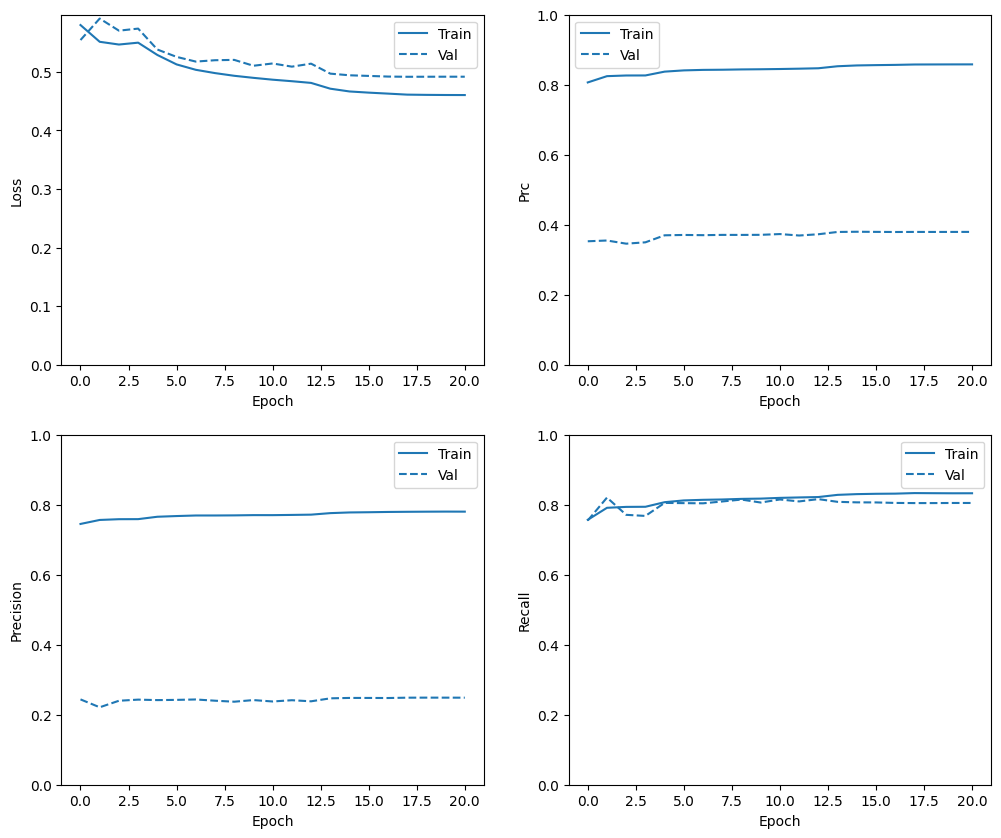

74/74 [==============================] - 1s 17ms/step
loss :  0.49325016140937805
cross entropy :  0.46539729833602905
Brier score :  0.1560910940170288
tp :  10900.0
fp :  32948.0
tn :  103536.0
fn :  2616.0
accuracy :  0.7629066705703735
precision :  0.2485860288143158
recall :  0.8064516186714172
auc :  0.8585411310195923
prc :  0.3865872025489807

Detected low conversion correctly (True Negatives):  103536
Detected low conversion wrongly (False Negatives):  2616
Detected high conversion correctly (True Positives):  10900
Detected high conversion wrongly (False Positives):  32948
Total high conversions:  13516


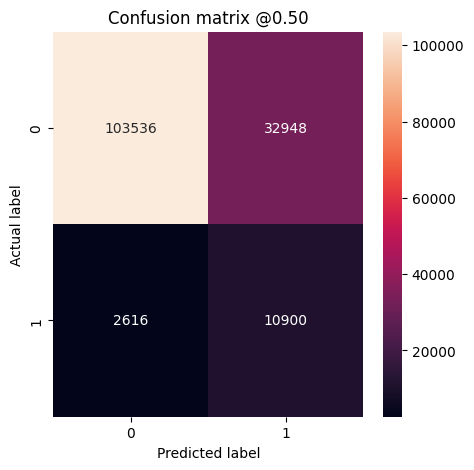

342/342 [==============================] - 6s 17ms/step


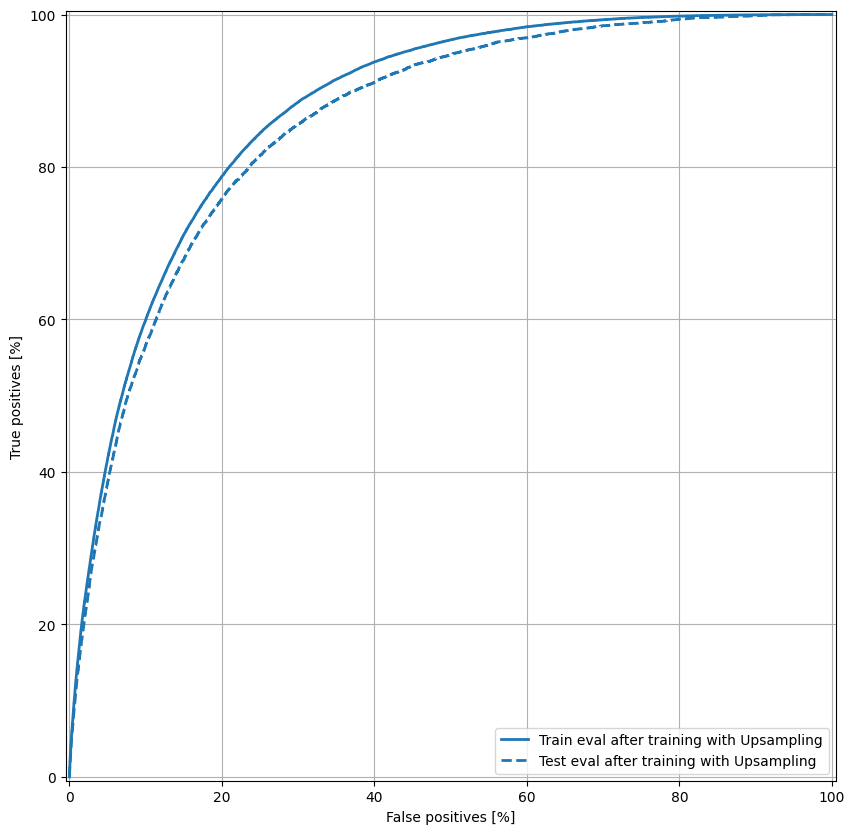

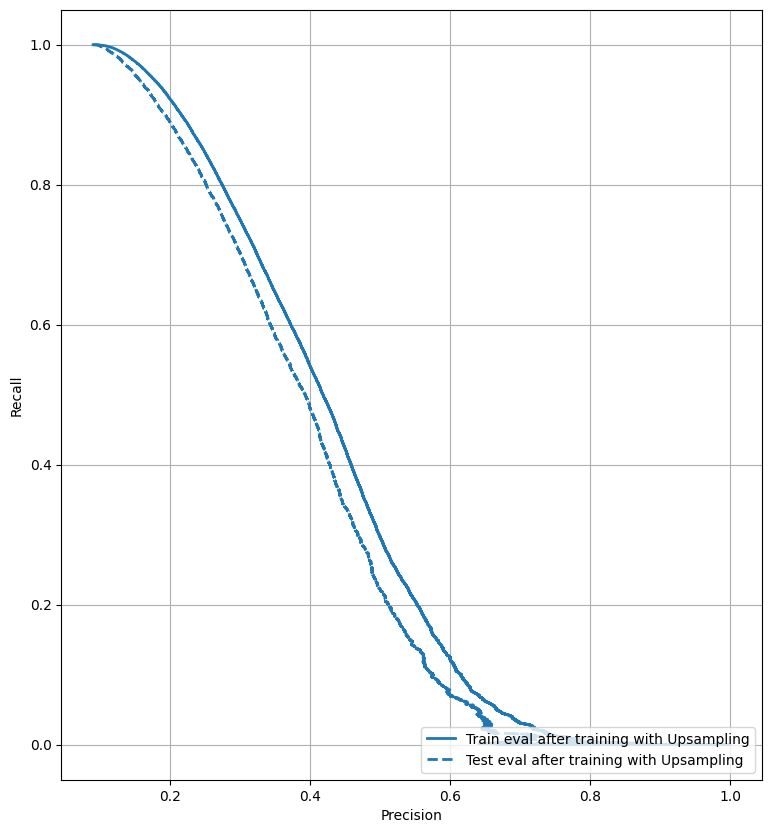

In [56]:
# metrics during training
plot_metrics(hist_upsampled)
plt.show()

# evaluation
y_pred_test = model.predict(x_test, batch_size=BATCH_SIZE)

evals = model.evaluate(x_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, evals):
  print(name, ': ', value)
print()

# confusion matrix
plot_cm(y_test, y_pred_test)
plt.show()


y_pred_train = model.predict(x_train, batch_size=BATCH_SIZE)

# ROC
plot_roc("Train eval after training with Upsampling", y_train, y_pred_train, color=colors[0])
plot_roc("Test eval after training with Upsampling", y_test, y_pred_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

# AUPRC
plot_prc("Train eval after training with Upsampling", y_train, y_pred_train, color=colors[0])
plot_prc("Test eval after training with Upsampling", y_test, y_pred_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

***
Ok, metrics looks better! In the Confusion Matrix we got good ratio of TP/FN.
<br>Well, now we are ready for model selection procedure.
***

***
## Model using automatic NN architecture search
***

In [ ]:
!pip install keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
# let's redefine the model builder for keras_tuner
def build_model_hp(hp, features_cnt : int, metrics : list = [], ):
    """
    builds a model with functional API
    """
    inputs = tf.keras.layers.Input(shape=(features_cnt,))
    h = inputs

    for l in range(hp.Int('layers', min_value=2, max_value=15, step=1)):
      h = tf.keras.layers.Dense(
          units = hp.Int(f'units_l{l}', min_value=32*2, max_value=32*32, step=32),
          activation = 'tanh',
          )(h)
      # if hp.Boolean(f'batchnorm_l{l}'):
      h = tf.keras.layers.BatchNormalization()(h)
    outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(h)

    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)

    model.compile(
        tf.keras.optimizers.Adam(learning_rate = 1e-3), #hp.Float('lr', min_value=0.0001, max_value=0.001, step=10.0, sampling='log')),
        loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

    return model

    kt.HyperParameters().Float()

In [ ]:
with strategy.scope():
  tuner = kt.BayesianOptimization(
      hypermodel=lambda x: build_model_hp(x, features_cnt=FEATURES_CNT, metrics=METRICS),
      objective=kt.Objective('val_prc', direction='max'),
      overwrite=True, #      !!!!!!!!!!! if TRUE: will erase progress in folder. If False: will proceed
      project_name='hp_FRUP',
  )

In [ ]:
# using upsampled train set

n_steps = max(1, x_train_upsampled.shape[0] // BATCH_SIZE) # steps per epoch

tuner.search(
    train_dataset_upsampled,
    steps_per_epoch = n_steps,
    epochs=10,
    validation_data=val_dataset)

In [ ]:
tuner.results_summary()

Results summary
Results in ./hp_FRUP
Showing 10 best trials
Objective(name="val_prc", direction="max")

Trial 00 summary
Hyperparameters:
layers: 2
units_l0: 320
units_l1: 96
Score: 0.3753237724304199

Trial 01 summary
Hyperparameters:
layers: 11
units_l0: 448
units_l1: 608
units_l2: 64
units_l3: 64
units_l4: 64
units_l5: 64
units_l6: 64
units_l7: 64
units_l8: 64
units_l9: 64
units_l10: 64
Score: 0.37060561776161194

Trial 06 summary
Hyperparameters:
layers: 13
units_l0: 672
units_l1: 608
units_l2: 192
units_l3: 992
units_l4: 640
units_l5: 352
units_l6: 1024
units_l7: 640
units_l8: 704
units_l9: 128
units_l10: 320
units_l11: 64
units_l12: 64
Score: 0.3699178099632263

Trial 05 summary
Hyperparameters:
layers: 5
units_l0: 640
units_l1: 800
units_l2: 832
units_l3: 704
units_l4: 928
units_l5: 832
units_l6: 704
units_l7: 224
units_l8: 768
units_l9: 736
units_l10: 896
Score: 0.36544567346572876

Trial 04 summary
Hyperparameters:
layers: 11
units_l0: 576
units_l1: 960
units_l2: 896
units_l3:

In [ ]:
# # Get the top 2 models.
# models = tuner.get_best_models(num_models=2)
# best_model = models[0]
# best_model.summary()

In [ ]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(2)
# Build the model with the best hp.
best_model = build_model_hp(hp=best_hps[0], features_cnt=FEATURES_CNT, metrics=METRICS)
best_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_10 (Dense)            (None, 320)               8640      
                                                                 
 batch_normalization_8 (Bat  (None, 320)               1280      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 96)                30816     
                                                                 
 batch_normalization_9 (Bat  (None, 96)                384       
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 1)                 97  

In [ ]:
# fully train it with callbacks
hist_bestmodel = best_model.fit(
    train_dataset_upsampled,
    validation_data = val_dataset,
    steps_per_epoch = n_steps,
    epochs = EPOCHS,
    callbacks = [rlp, es],
)

Epoch 1/100
621/621 [==============================] - 12s 15ms/step - loss: 0.5007 - cross entropy: 0.4765 - Brier score: 0.1562 - tp: 819202.0000 - fp: 256834.0000 - tn: 774444.0000 - fn: 211856.0000 - accuracy: 0.7727 - precision: 0.7613 - recall: 0.7945 - auc: 0.8514 - prc: 0.8318 - val_loss: 0.5188 - val_cross entropy: 0.5188 - val_Brier score: 0.1747 - val_tp: 11014.0000 - val_fp: 38207.0000 - val_tn: 98276.0000 - val_fn: 2503.0000 - val_accuracy: 0.7286 - val_precision: 0.2238 - val_recall: 0.8148 - val_auc: 0.8462 - val_prc: 0.3652 - lr: 0.0010
Epoch 2/100
621/621 [==============================] - 7s 11ms/step - loss: 0.4753 - cross entropy: 0.4753 - Brier score: 0.1554 - tp: 508415.0000 - fp: 157326.0000 - tn: 478566.0000 - fn: 127501.0000 - accuracy: 0.7760 - precision: 0.7637 - recall: 0.7995 - auc: 0.8528 - prc: 0.8342 - val_loss: 0.4948 - val_cross entropy: 0.4948 - val_Brier score: 0.1658 - val_tp: 10882.0000 - val_fp: 34799.0000 - val_tn: 101684.0000 - val_fn: 2635.0000

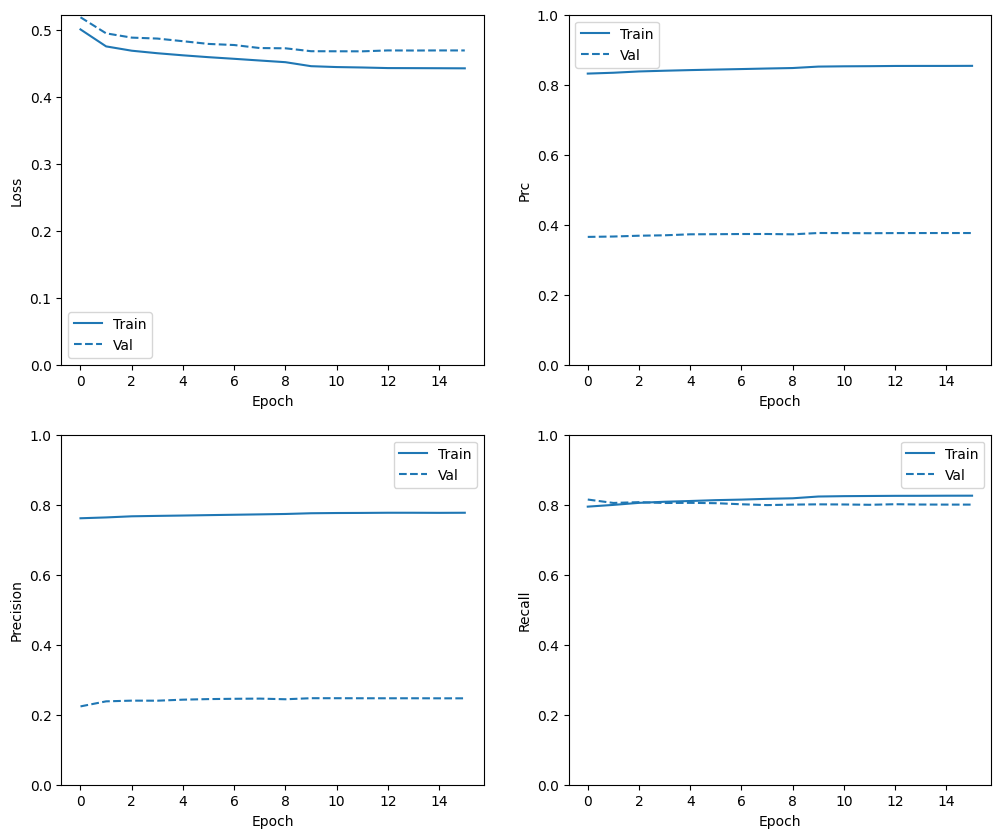

74/74 [==============================] - 0s 2ms/step
loss :  0.4682629704475403
cross entropy :  0.4682629704475403
Brier score :  0.15643101930618286
tp :  10814.0
fp :  33018.0
tn :  103466.0
fn :  2702.0
accuracy :  0.7618666887283325
precision :  0.2467147260904312
recall :  0.8000887632369995
auc :  0.8549261689186096
prc :  0.380036860704422

Detected low conversion correctly (True Negatives):  103466
Detected low conversion wrongly (False Negatives):  2702
Detected high conversion correctly (True Positives):  10814
Detected high conversion wrongly (False Positives):  33018
Total high conversions:  13516


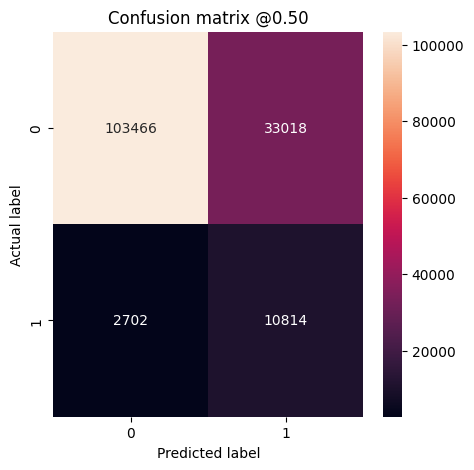

342/342 [==============================] - 1s 2ms/step


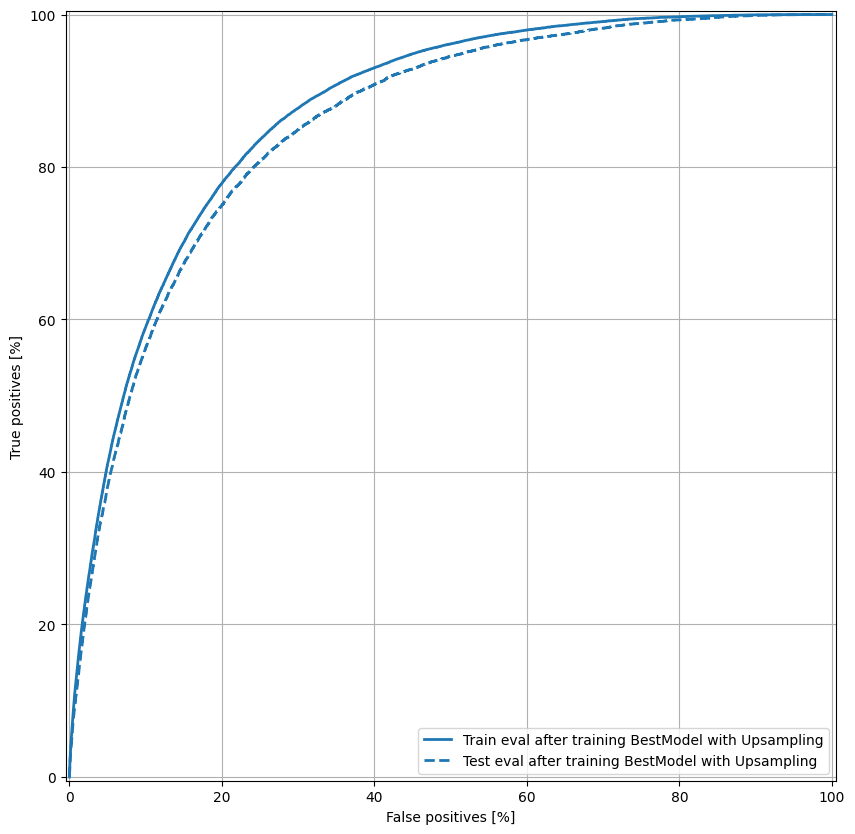

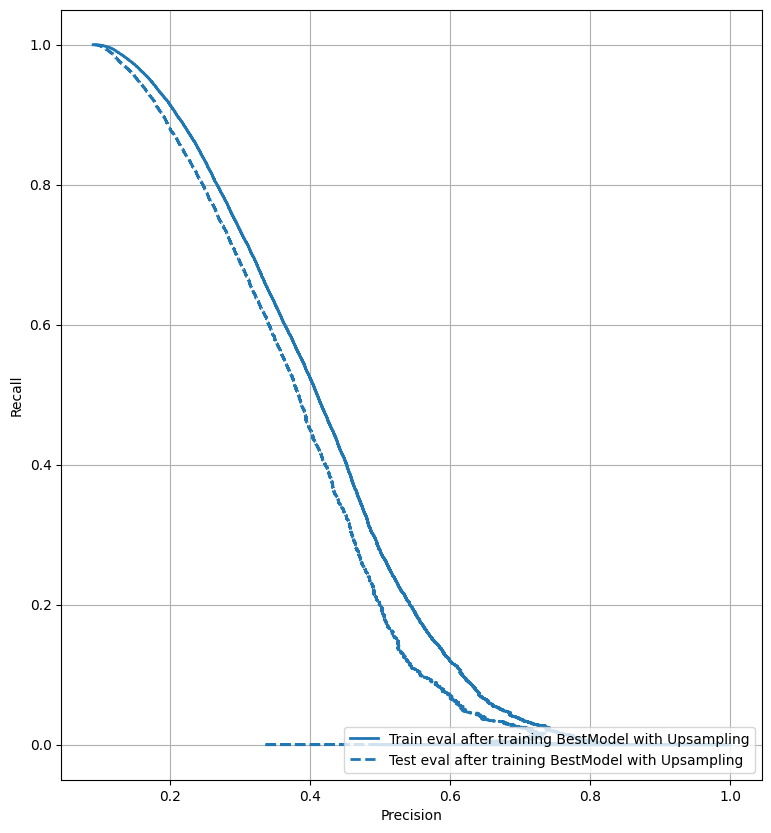

In [ ]:
#and let's have a look
# metrics during training
plot_metrics(hist_bestmodel)
plt.show()

# evaluation
y_pred_test = best_model.predict(x_test, batch_size=BATCH_SIZE)

evals = best_model.evaluate(x_test, y_test, verbose=0)
for name, value in zip(best_model.metrics_names, evals):
  print(name, ': ', value)
print()

# confusion matrix
plot_cm(y_test, y_pred_test)
plt.show()


y_pred_train = best_model.predict(x_train, batch_size=BATCH_SIZE)

# ROC
plot_roc("Train eval after training BestModel with Upsampling", y_train, y_pred_train, color=colors[0])
plot_roc("Test eval after training BestModel with Upsampling", y_test, y_pred_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

# AUPRC
plot_prc("Train eval after training BestModel with Upsampling", y_train, y_pred_train, color=colors[0])
plot_prc("Test eval after training BestModel with Upsampling", y_test, y_pred_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
# save
best_model.save('best_model')

In [ ]:
# load
# best_model = tf.keras.models.load_model('best_model')

***
# Ideas for improving
1) We must preprocess our data more. We can use for this purpose "FeatureSpace" (tf.keras.utils.FeatureSpace) - it's very flexible and smart. One one hand we have too mane Nominal Categorical features and straight one-hot encoding would explode dimensionality of input space, but with "FeatureSpace" we can explicitly choose and so squize the dimensionality (e.g. 5000 unique values encode in 32-dimensional vector, but not in 5000 one-hot-dimensional, also cross-encode(concat and encode) all geo values) and it is relatively easy to connect to DataSet object from TensorFlow. I would do this at the first place. <br>
2) Also we can experiment with random forests, since they are usually good with structured tabular data. We can also use for this purpose "tensorflow_decision_forests" package (utilizing the speed of gpu + gradient-boosted forest).
<br>
<br>
I know that this two points will get us increase in the result.
***

In [ ]:
y_pred_test_high = y_pred_test[(y_test==1.0).reshape(-1)]
print('predicted probabilities of conversion in actualy high conversion cases\n', y_pred_test_high)
print('\nand its mean is: ', np.mean(y_pred_test_high))

predicted probabilities of conversion in actualy high conversion cases
 [[0.46261266]
 [0.8705466 ]
 [0.7325958 ]
 ...
 [0.8737123 ]
 [0.4628317 ]
 [0.5898431 ]]

and its mean is:  0.69031215


In [ ]:
y_pred_test_low = y_pred_test[(y_test==0.0).reshape(-1)]
print('predicted probabilities of conversion in actualy low conversion cases\n', y_pred_test_low)
print('\nand its mean is: ', np.mean(y_pred_test_low))

predicted probabilities of conversion in actualy low conversion cases
 [[0.04093982]
 [0.43342635]
 [0.02289107]
 ...
 [0.13715191]
 [0.4251424 ]
 [0.04595594]]

and its mean is:  0.29228616


***
simply speaking on average we predicting correctly. but I would do mentioned above point 1 at least (preprocess data better. I can see from the plots that even NN struggle a bit in a given feature space)
***